<a href="https://colab.research.google.com/github/Krishnitha1213/Detecting_Malicious_urls_using_ml-/blob/master/Copy_of_18July24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Importing dependencies
import re
import warnings
warnings.filterwarnings('ignore')

!pip install tld
import tld
from tld import get_tld
#tld Module: This module typically stands for "top-level domain". It's used for extracting the top-level domain (TLD) from a given URL.
#TLDs are the highest level in the hierarchical Domain Name System (DNS) of the internet. For instance, in the URL "https://www.example.com", the TLD is ".com".
#The get_tld function in the tld module is used to extract this information. It provides a way to parse URLs and retrieve the TLD portion.

from urllib.parse import urlparse
#urllib.parse Module: This module is part of Python's standard library and provides functions for parsing URLs.
#The urlparse function is used to break down a URL into its components, such as the scheme, network location, path, query parameters, etc.

# Machine Learning Packages

# To install : pip install scikit-learn
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
#TfidfVectorizer is a class in the scikit-learn library, which is a popular machine learning library for Python.
#It is used for converting a collection of raw documents into a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features.

In [ ]:
urldata = pd.read_csv(r"urldata2.csv")

In [ ]:
urldata.head()

,Unnamed: 0,url,label,result
0,0,https://www.google.com,benign,0
1,1,https://www.youtube.com,benign,0
2,2,https://www.facebook.com,benign,0
3,3,https://www.baidu.com,benign,0
4,4,https://www.wikipedia.org,benign,0


In [ ]:
urldata = urldata.drop(['Unnamed: 0'],axis=1)

In [ ]:
# to get more information
urldata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89732 entries, 0 to 89731
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     89732 non-null  object
 1   label   89732 non-null  object
 2   result  89732 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.1+ MB


In [ ]:
urldata.groupby('label').count()

,url,result
label,,
benign,44866,44866
malicious,44866,44866


In [ ]:
urldata.shape

(89732, 3)

In [ ]:
#  to check the null values or missing values
urldata.isnull().sum()

url       0
label     0
result    0
dtype: int64

In [ ]:
# to get the statistical information
urldata.describe()

,result
count,89732.000000
mean,0.500000
std,0.500003
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [ ]:
duplicate_rows = urldata[urldata.duplicated()]

# If 'duplicate_rows' is empty, there are no duplicate rows in the DataFrame
if duplicate_rows.empty:
    print("No duplicate rows found.")
else:
    print("Duplicate rows found.")

No duplicate rows found.


In [ ]:
num_duplicate_rows = len(duplicate_rows)
print("Number of duplicate rows:", num_duplicate_rows)

Number of duplicate rows: 0


In [ ]:
#Length of URL
urldata['url_length'] = urldata['url'].apply(lambda i: len(str(i)))  #www.google.com  : no of characters

In [ ]:
# Define a function to extract hostname length
def get_hostname_length(url):
    try:
        parsed_url = urlparse(url)
        return len(parsed_url.netloc)
    except Exception as e:
        print(f"Error parsing URL '{url}': {e}")
        return -1  # Indicate error with a sentinel value

# Apply the function to create the 'hostname_length' column
urldata['hostname_length'] = urldata['url'].apply(get_hostname_length)

In [ ]:
#Path Length
urldata['path_length'] = urldata['url'].apply(lambda i: len(urlparse(i).path))

In [ ]:
#First Directory Length

def fd_length(url):
    try:
        urlpath = urlparse(url).path
        if len(urlpath.split('/')) > 1:
            return len(urlpath.split('/')[1])
        else:
            return 0
    except ValueError:
        return 0

urldata['fd_length'] = urldata['url'].apply(fd_length)


In [ ]:
#Length of Top Level Domain
urldata['tld'] = urldata['url'].apply(lambda i: get_tld(i,fail_silently=True))
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

urldata['tld_length'] = urldata['tld'].apply(lambda i: tld_length(i))

In [ ]:
urldata = urldata.drop(['tld'],axis=1)
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld_length
0,https://www.google.com,benign,0,22,14,0,0,3
1,https://www.youtube.com,benign,0,23,15,0,0,3
2,https://www.facebook.com,benign,0,24,16,0,0,3
3,https://www.baidu.com,benign,0,21,13,0,0,3
4,https://www.wikipedia.org,benign,0,25,17,0,0,3


In [ ]:
urldata['count-'] = urldata['url'].apply(lambda i: i.count('-'))
urldata['count@'] = urldata['url'].apply(lambda i: i.count('@'))
urldata['count?'] = urldata['url'].apply(lambda i: i.count('?'))
urldata['count%'] = urldata['url'].apply(lambda i: i.count('%'))
urldata['count.'] = urldata['url'].apply(lambda i: i.count('.'))
urldata['count='] = urldata['url'].apply(lambda i: i.count('='))
urldata['count-http'] = urldata['url'].apply(lambda i : i.count('http'))
urldata['count-https'] = urldata['url'].apply(lambda i : i.count('https'))
urldata['count-www'] = urldata['url'].apply(lambda i: i.count('www'))

In [ ]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
urldata['count-digits']= urldata['url'].apply(lambda i: digit_count(i))

In [ ]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
urldata['count-letters']= urldata['url'].apply(lambda i: letter_count(i))

In [ ]:
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
urldata['count_dir'] = urldata['url'].apply(lambda i: no_of_dir(i))

In [ ]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir
0,https://www.google.com,benign,0,22,14,0,0,3,0,0,0,0,2,0,1,1,1,0,17,0
1,https://www.youtube.com,benign,0,23,15,0,0,3,0,0,0,0,2,0,1,1,1,0,18,0
2,https://www.facebook.com,benign,0,24,16,0,0,3,0,0,0,0,2,0,1,1,1,0,19,0
3,https://www.baidu.com,benign,0,21,13,0,0,3,0,0,0,0,2,0,1,1,1,0,16,0
4,https://www.wikipedia.org,benign,0,25,17,0,0,3,0,0,0,0,2,0,1,1,1,0,20,0


In [ ]:
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return -1
    else:
        # print 'No matching pattern found'
        return 1
urldata['use_of_ip'] = urldata['url'].apply(lambda i: having_ip_address(i))

In [ ]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return -1
    else:
        return 1
urldata['short_url'] = urldata['url'].apply(lambda i: shortening_service(i))

In [ ]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld_length,count-,count@,...,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,short_url
0,https://www.google.com,benign,0,22,14,0,0,3,0,0,...,2,0,1,1,1,0,17,0,1,1
1,https://www.youtube.com,benign,0,23,15,0,0,3,0,0,...,2,0,1,1,1,0,18,0,1,1
2,https://www.facebook.com,benign,0,24,16,0,0,3,0,0,...,2,0,1,1,1,0,19,0,1,1
3,https://www.baidu.com,benign,0,21,13,0,0,3,0,0,...,2,0,1,1,1,0,16,0,1,1
4,https://www.wikipedia.org,benign,0,25,17,0,0,3,0,0,...,2,0,1,1,1,0,20,0,1,1


In [ ]:
# Features
x = urldata["url"]

In [ ]:
# Labels
y = urldata["result"]

In [ ]:
x.head()

0       https://www.google.com
1      https://www.youtube.com
2     https://www.facebook.com
3        https://www.baidu.com
4    https://www.wikipedia.org
Name: url, dtype: object

In [ ]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: result, dtype: int64

In [ ]:
# Using Tokenizer
vectorizer = TfidfVectorizer()

In [ ]:
# Store vectors into X variable as Our XFeatures
X = vectorizer.fit_transform(x)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
X_train.shape[0],len(y_train),X_test.shape[0],len(y_test)


(71785, 71785, 17947, 17947)

Text(0, 0.5, 'Number Of URLs')

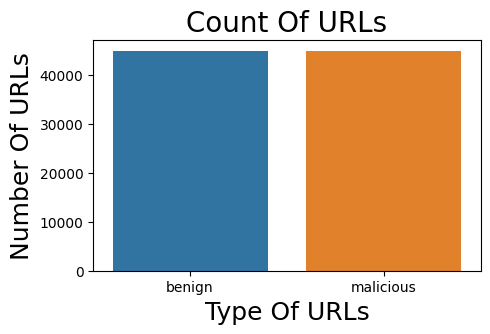

In [ ]:
plt.figure(figsize=(5,3))
sns.countplot(x='label',data=urldata,hue='label')
plt.title("Count Of URLs",fontsize=20)
plt.xlabel("Type Of URLs",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)

Text(0, 0.5, 'Number Of Urls')

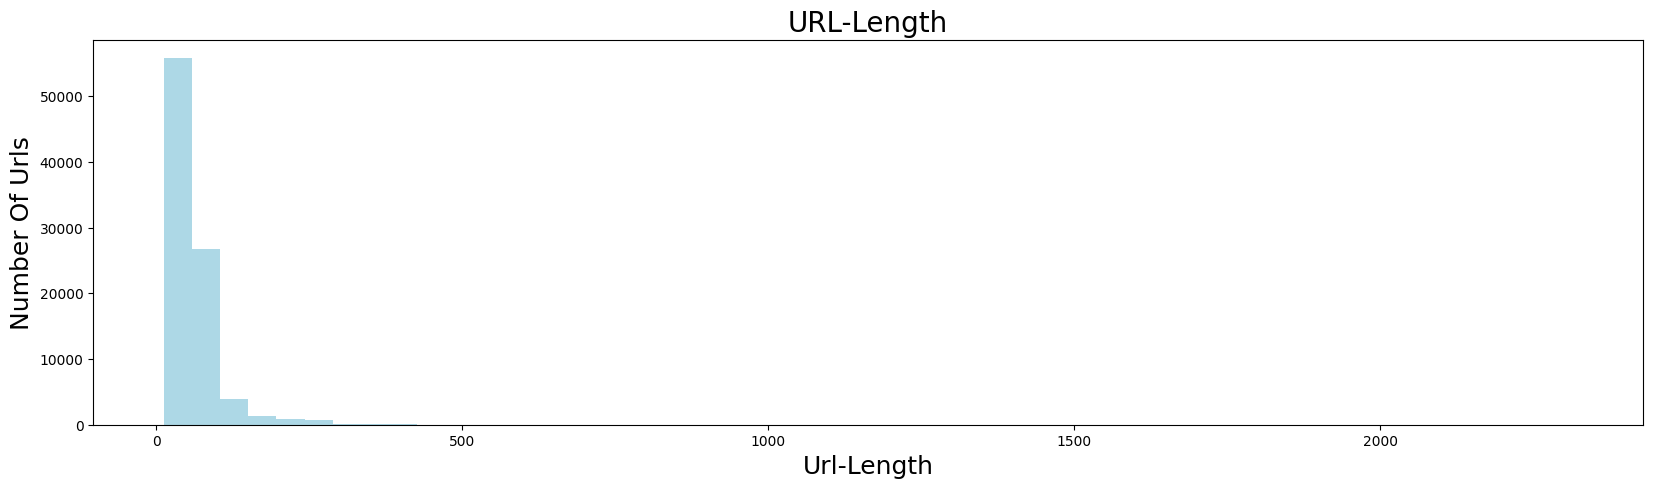

In [ ]:
plt.figure(figsize=(20,5))
plt.hist(urldata['url_length'],bins=50,color='LightBlue')
plt.title("URL-Length",fontsize=20)
plt.xlabel("Url-Length",fontsize=18)
plt.ylabel("Number Of Urls",fontsize=18)

Text(0, 0.5, 'Number Of Urls')

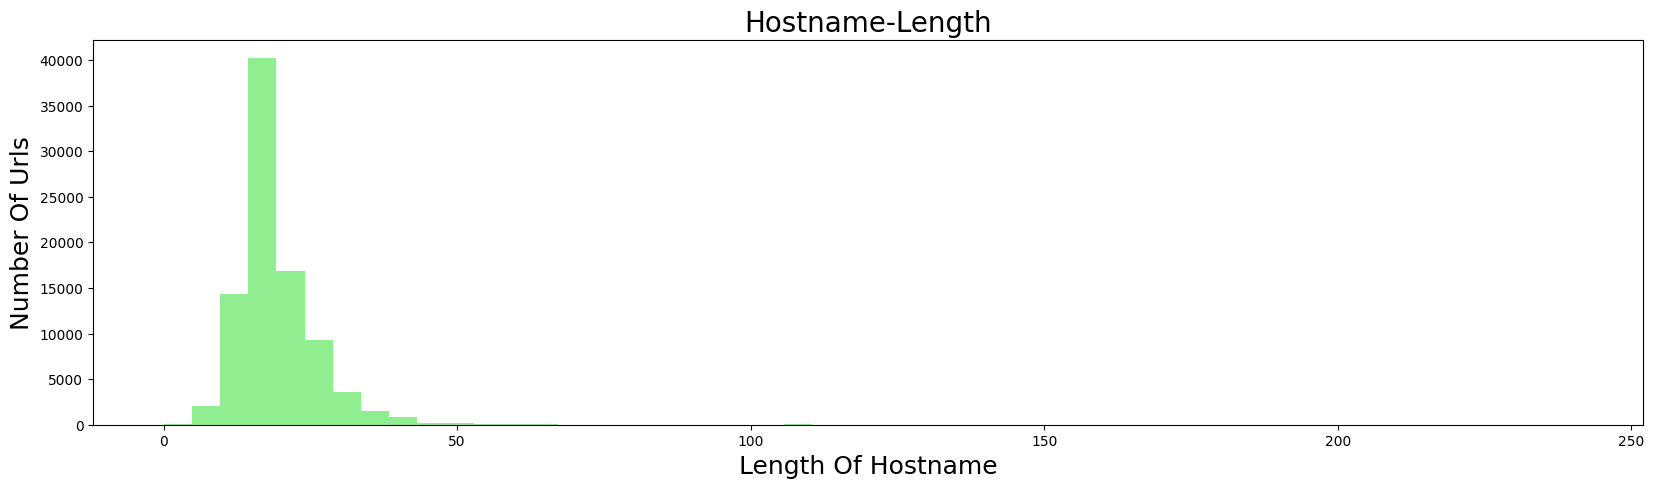

In [ ]:
plt.figure(figsize=(20,5))
plt.hist(urldata['hostname_length'],bins=50,color='Lightgreen')
plt.title("Hostname-Length",fontsize=20)
plt.xlabel("Length Of Hostname",fontsize=18)
plt.ylabel("Number Of Urls",fontsize=18)

Text(0, 0.5, 'Number Of Urls')

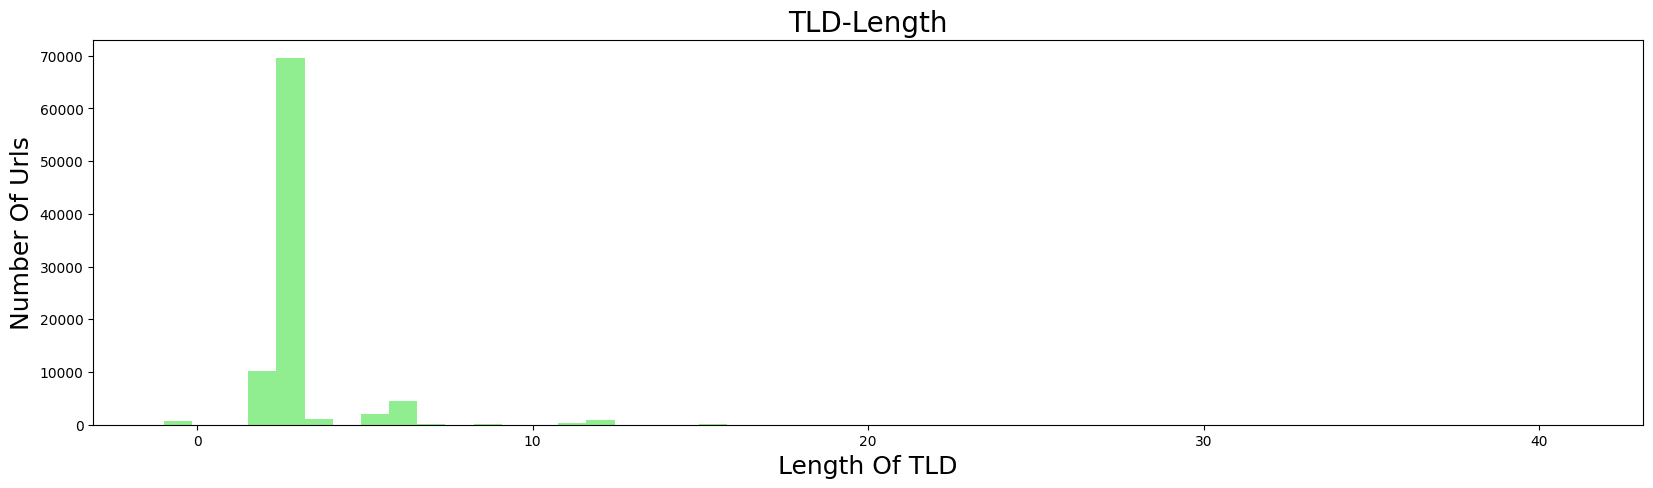

In [ ]:
plt.figure(figsize=(20,5))
plt.hist(urldata['tld_length'],bins=50,color='Lightgreen')
plt.title("TLD-Length",fontsize=20)
plt.xlabel("Length Of TLD",fontsize=18)
plt.ylabel("Number Of Urls",fontsize=18)


Text(0, 0.5, 'Number Of URLs')

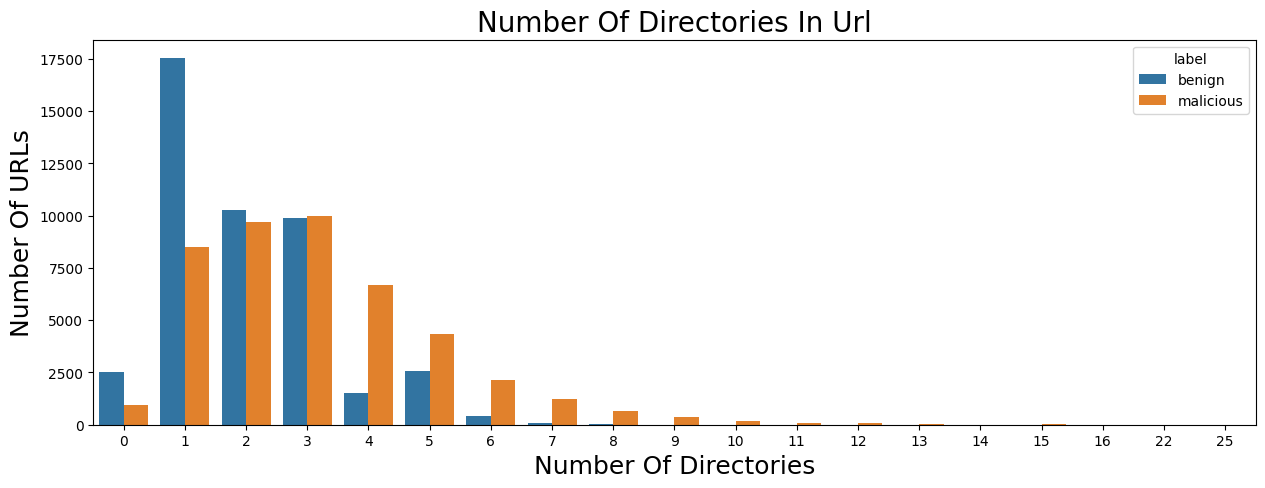

In [ ]:
plt.figure(figsize=(15,5))
plt.title("Number Of Directories In Url",fontsize=20)
sns.countplot(x='count_dir',data=urldata,hue='label')
plt.xlabel("Number Of Directories",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

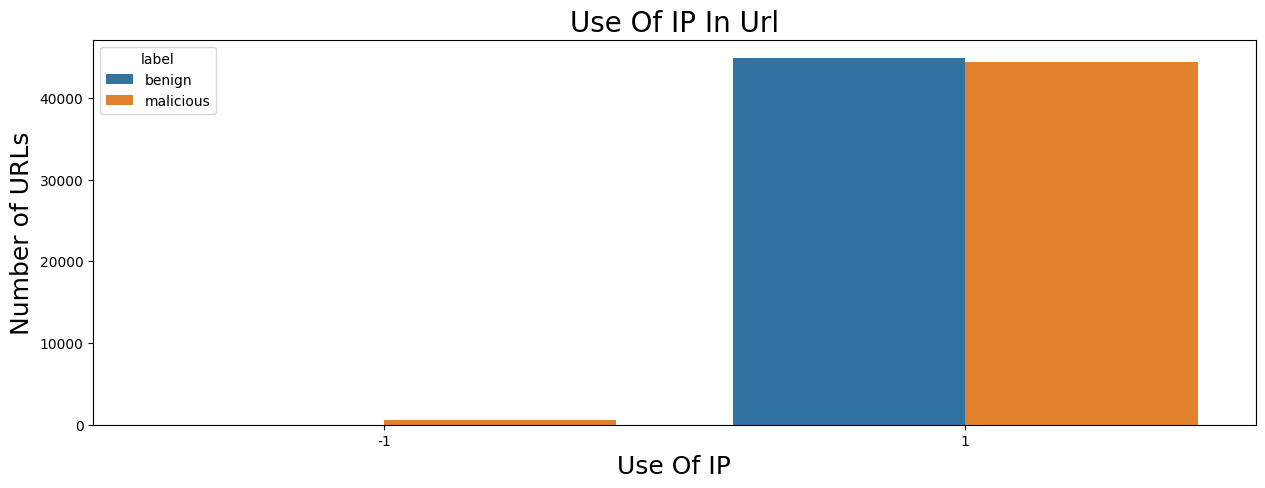

In [ ]:
plt.figure(figsize=(15,5))
plt.title("Use Of IP In Url",fontsize=20)
plt.xlabel("Use Of IP",fontsize=18)
sns.countplot(x='use_of_ip',data=urldata,hue='label')
plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

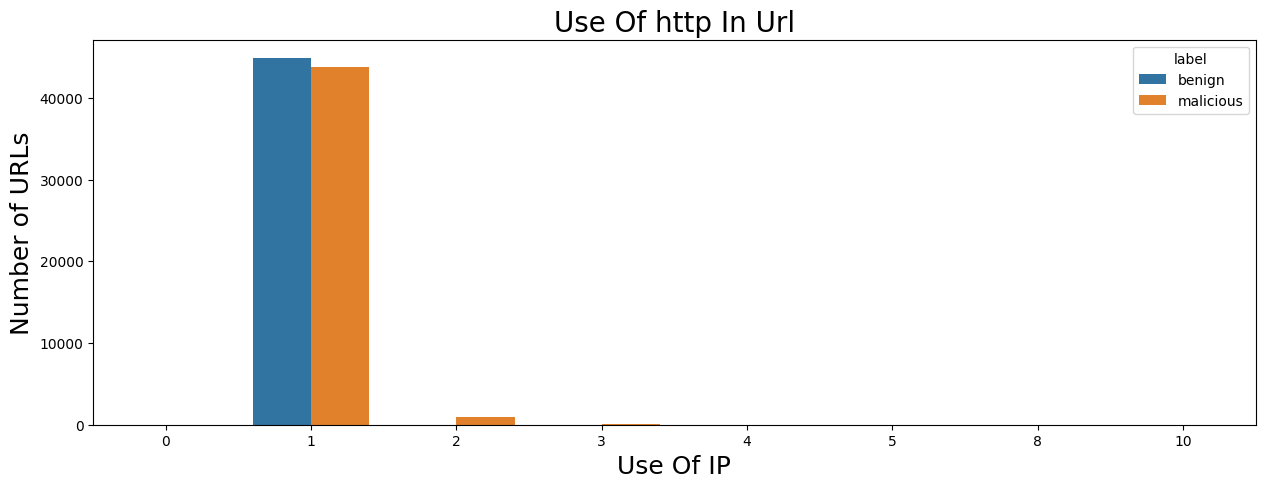

In [ ]:
plt.figure(figsize=(15,5))
plt.title("Use Of http In Url",fontsize=20)
plt.xlabel("Use Of IP",fontsize=18)
sns.countplot(x='count-http',data=urldata,hue='label')
plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number Of URLs')

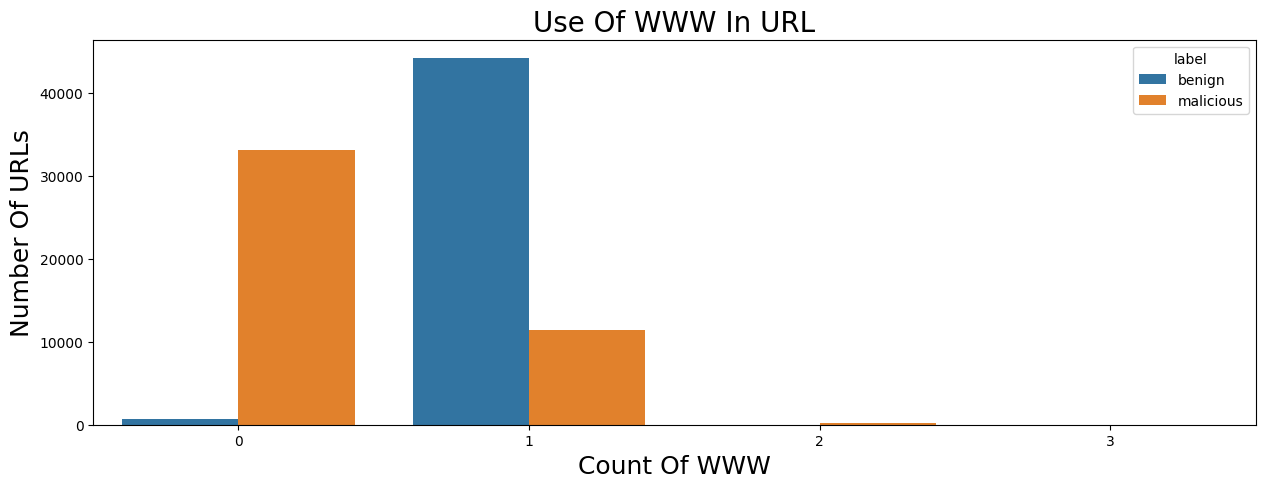

In [ ]:
plt.figure(figsize=(15,5))
plt.title("Use Of WWW In URL",fontsize=20)
plt.xlabel("Count Of WWW",fontsize=18)
sns.countplot(x='count-www',data=urldata,hue='label')
plt.ylabel("Number Of URLs",fontsize=18)

In [ ]:
logit = LogisticRegression()
logit.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Accuracy of Our Model Using Train Data
print(f"Logistic Regression Training Accuracy: {logit.score(X_train, y_train):.2%}")

Logistic Regression Training Accuracy: 99.45%


In [ ]:
# Accuracy of Our Model Using Test Data
print(f"Logistic Regression Accuracy: {logit.score(X_test, y_test):.2%}")

Logistic Regression Accuracy: 99.10%


In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
# Accuracy of Our Model Using Test Data
print(f"DecisionTreeClassifier Training Accuracy: {tree.score(X_train, y_train):.2%}")

DecisionTreeClassifier Training Accuracy: 100.00%


In [ ]:
# Accuracy of Our Model Using Test Data
print(f"DecisionTreeClassifier Accuracy: {tree.score(X_test, y_test):.2%}")

DecisionTreeClassifier Accuracy: 99.24%


In [ ]:
random = RandomForestClassifier()
random.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# Accuracy of Our Model Using Test Data
print(f"RandomForestClassifier Training Accuracy: {random.score(X_train, y_train):.2%}")

RandomForestClassifier Training Accuracy: 100.00%


In [ ]:
# Accuracy of Our Model Using Test Data
print(f"RandomForestClassifier Accuracy: {random.score(X_test, y_test):.2%}")

RandomForestClassifier Accuracy: 99.34%


In [ ]:
svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [ ]:
# Accuracy of Our Model Using Test Data
print(f"SVC Training Accuracy: {svc.score(X_train, y_train):.2%}")

SVC Training Accuracy: 99.90%


In [ ]:
# Accuracy of Our Model Using Test Data
print(f"SVC Accuracy: {svc.score(X_test, y_test):.2%}")

SVC Accuracy: 99.25%


In [ ]:
import joblib

#save the model and vectorizer
joblib.dump(random, "RandomForestModel.pkl", protocol=2)
joblib.dump(vectorizer, "TfidfVectorizer.pkl", protocol=2)

['TfidfVectorizer.pkl']

In [ ]:
model = joblib.load(r"RandomForestModel.pkl")
vec = joblib.load(r"TfidfVectorizer.pkl")

In [ ]:
labels = ["BENIGN","MALICIOUS"]

In [ ]:
test1 = model.predict(vec.transform(["https://www.monographicreview.org/"]))

In [ ]:
labels[test1[0]]

'BENIGN'

In [ ]:
test2 = model.predict(vec.transform(["http://signin.resolver-access.cf/webapps/a4a86/"]))

In [ ]:
labels[test2[0]]

'MALICIOUS'

In [ ]:
test3 = model.predict(vec.transform(["http://problem-page.in/hokikausayangpial/log.php"]))
labels[test3[0]]

'MALICIOUS'

In [ ]:
test4 = model.predict(vec.transform(["https://www.facebook.com"]))
labels[test4[0]]

'BENIGN'

In [ ]:
accuracy = model.score(X_test,y_test)
print(f"Accuracy of Random Forest Classifier: {accuracy:.2%}")

Accuracy of Random Forest Classifier: 99.34%


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print("\n*================ CLASSIFICATION REPORT ================*\n")
print(classification_report(y_test, y_pred))


*================ CLASSIFICATION REPORT ================*

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9032
           1       0.99      0.99      0.99      8915

    accuracy                           0.99     17947
   macro avg       0.99      0.99      0.99     17947
weighted avg       0.99      0.99      0.99     17947



In [ ]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[8981,   51],
       [  67, 8848]])


* ======================== CONFUSION MATRIX ======================== *



<Axes: >

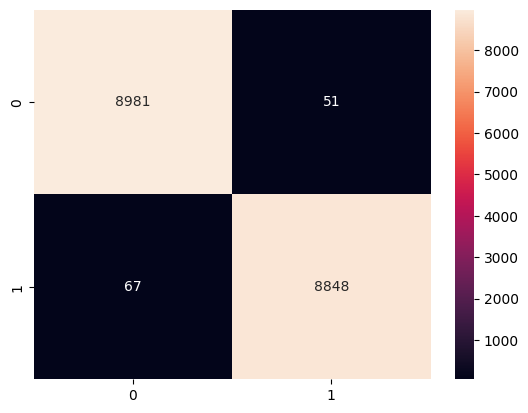

In [ ]:
print("\n* ======================== CONFUSION MATRIX ======================== *\n")
sns.heatmap(cm,annot=True,fmt='d')


*================ CLASSIFICATION REPORT OF LOGISTIC REGRESSION ================*

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9032
           1       0.99      0.99      0.99      8915

    accuracy                           0.99     17947
   macro avg       0.99      0.99      0.99     17947
weighted avg       0.99      0.99      0.99     17947


* ======================== CONFUSION MATRIX OF LOGISTIC REGRESSION ======================== *



<Axes: >

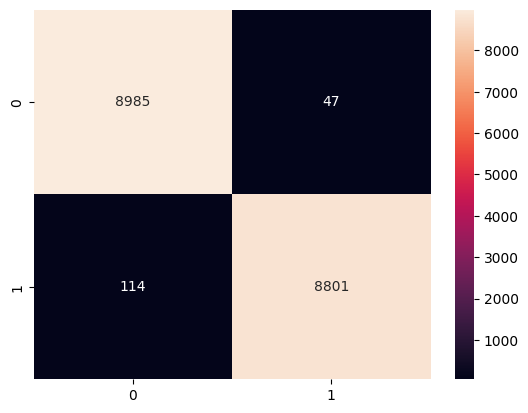

In [ ]:
logistic_pred = logit.predict(X_test)
print("\n*================ CLASSIFICATION REPORT OF LOGISTIC REGRESSION ================*\n")
print(classification_report(y_test, logistic_pred))
log_cm = confusion_matrix(y_test,logistic_pred)
print("\n* ======================== CONFUSION MATRIX OF LOGISTIC REGRESSION ======================== *\n")
sns.heatmap(log_cm,annot=True,fmt='d')


*================ CLASSIFICATION REPORT OF DECISION TREE CLASSIFIER ================*

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9032
           1       0.99      0.99      0.99      8915

    accuracy                           0.99     17947
   macro avg       0.99      0.99      0.99     17947
weighted avg       0.99      0.99      0.99     17947


* ======================== CONFUSION MATRIX OF DECISION TREE CLASSIFIER ======================== *



<Axes: >

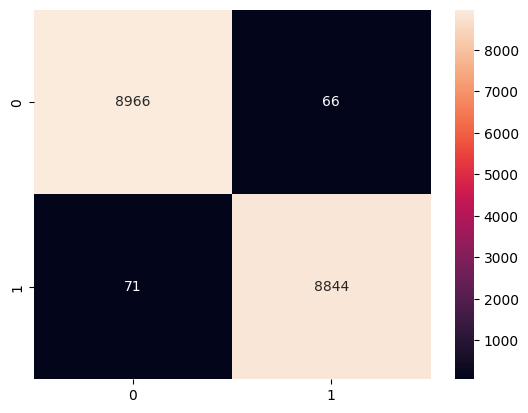

In [ ]:
decision_pred = tree.predict(X_test)
print("\n*================ CLASSIFICATION REPORT OF DECISION TREE CLASSIFIER ================*\n")
print(classification_report(y_test, decision_pred))
decision_cm = confusion_matrix(y_test,decision_pred)
print("\n* ======================== CONFUSION MATRIX OF DECISION TREE CLASSIFIER ======================== *\n")
sns.heatmap(decision_cm,annot=True,fmt='d')


*================ CLASSIFICATION REPORT OF SVC ================*

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9032
           1       0.99      0.99      0.99      8915

    accuracy                           0.99     17947
   macro avg       0.99      0.99      0.99     17947
weighted avg       0.99      0.99      0.99     17947


* ======================== CONFUSION MATRIX OF SVC ======================== *



<Axes: >

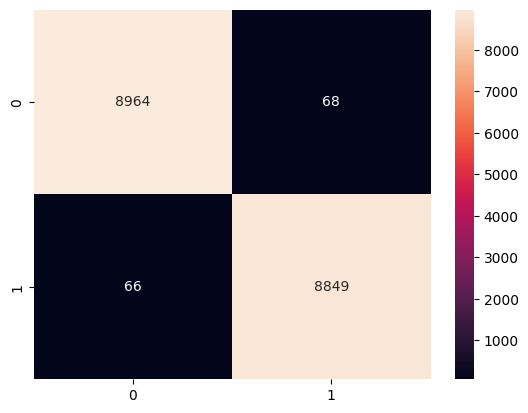

In [ ]:
SVC_pred = svc.predict(X_test)
print("\n*================ CLASSIFICATION REPORT OF SVC ================*\n")
print(classification_report(y_test, SVC_pred))
SVC_cm = confusion_matrix(y_test,SVC_pred)
print("\n* ======================== CONFUSION MATRIX OF SVC ======================== *\n")
sns.heatmap(SVC_cm,annot=True,fmt='d')